In [1]:
%load_ext autoreload

In [33]:
%autoreload
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import time
from scipy.stats import poisson
from sklearn import metrics


import torch
import torch.distributions as dist

import umap.umap_ as umap

from hmmlearn import hmm
from model import HMMPoisson
from utils import *

# Import data

In [3]:
df = pd.read_csv("df.csv")
X_pd = df.drop(columns= ["headAngel", "sin_angel", "cos_angel"]) # Droping unimportant columns and head angel
y = df.headAngel

# Remove inactive neurons

In [4]:
df_pure = df[~np.isnan(df["headAngel"])]

X_pure = df_pure.drop(columns= ["headAngel", "sin_angel", "cos_angel"])
y_pure = df_pure.headAngel

X_pure = X_pure.loc[:,X_pure.sum(axis=0) > 100]

In [5]:
X_pure.shape

(3553, 59)

# Vizualization

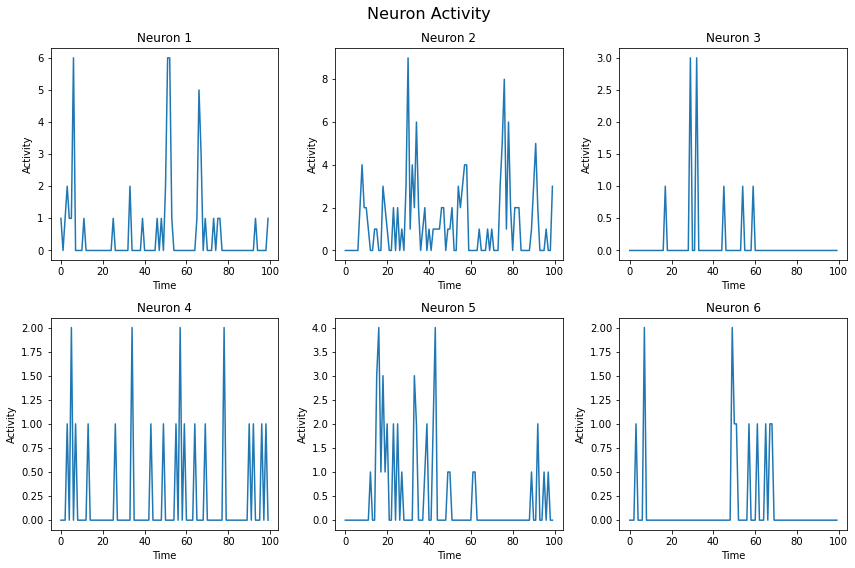

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle("Neuron Activity", fontsize=16)

t = 100 

data = X_pure
i = 0
for cell in data.columns[0:6]:
    row, col = divmod(i,3)
    ax = axes[row, col]
    
    ax.plot(range(t), data[cell][0:t])
    ax.set_title(f"Neuron {i+1}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Activity")
    i += 1

# Adjust spacing between subplots
plt.tight_layout()

# Show the subplots
plt.show()

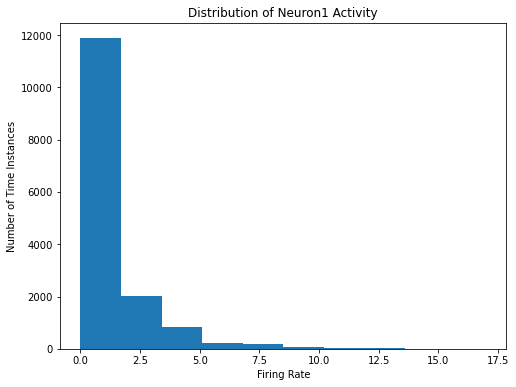

In [7]:
# Create a bar plot for the distribution of Neuron1's activity
plt.figure(figsize=(8, 6))

plt.hist(df["cell_0"], histtype="stepfilled")

# Set labels and title
plt.xlabel('Firing Rate')
plt.ylabel('Number of Time Instances')
plt.title('Distribution of Neuron1 Activity')

# Show the plot
plt.show()


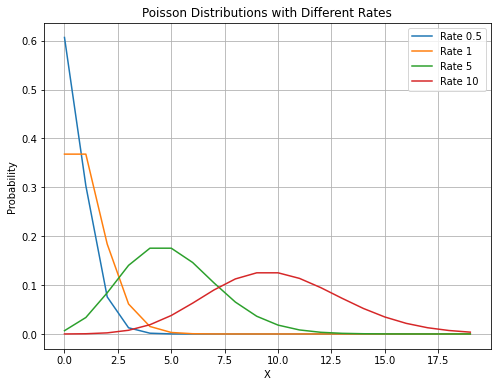

In [8]:
rates = [0.5, 1, 5, 10]
x = np.arange(0, 20)  # Adjust the range based on your preference

plt.figure(figsize=(8, 6))

for rate in rates:
    pmf = poisson.pmf(x, mu=rate)
    plt.plot(x, pmf, label=f'Rate {rate}')

plt.title('Poisson Distributions with Different Rates')
plt.xlabel('X')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()

# UMAP

In [9]:
X_scaled = StandardScaler().fit_transform(X_pure)

reducer = umap.UMAP(n_neighbors=50, min_dist=1)

embedding = reducer.fit_transform(X_scaled)

In [10]:
def map_list_to_segments(values, num_segments=10):
    segment_indices = []

    for value in values:
        if value < 0:
            value = 0
        elif value >= 2 * np.pi:
            value = 2 * np.pi - 1e-6  # To ensure that 2π gets mapped to the last segment.
        
        segment_width = (2 * np.pi) / num_segments
        segment_index = int(value / segment_width)
        segment_indices.append(segment_index)

    return segment_indices

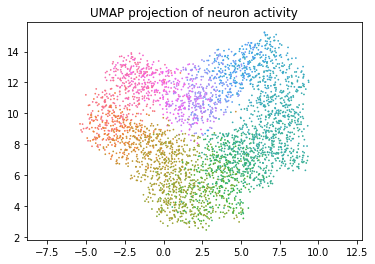

In [11]:
segment_hd = map_list_to_segments(y_pure, len(y_pure))
custom_palette = sns.color_palette("husl", len(segment_hd))

plt.scatter(
    embedding[:, 0],
    embedding[:, 1], c=[custom_palette[x] for x in segment_hd], s=0.5)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of neuron activity');

# Modeling

## Own model

In [ ]:
n_states = 10
X = torch.tensor(X_pd.values)
n_retraining = 1
m_dimensions = X.shape[1]

model_list = list()
score_list = list()
start_time = time.time()

for idx in range(n_retraining):
    model = HMMPoisson(n_states = n_states, m_dimensions=m_dimensions, verbose=True, max_itterations = 8, tolerance = 500)
    model.fit(X)

    model_list.append(model)
    score_list.append(model.forward(X).item())
    print(f'Score: {score_list[-1]}')
print("--- %s seconds ---" % (time.time() - start_time))

1 -2309528.2500  +inf
2 -1079146.1250  +1230382.125
3 -941929.5625  +137216.5625
4 -916919.6250  +25009.9375
5 -905170.1250  +11749.5
6 -900882.8750  +4287.25
7 -900040.7500  +842.125
8 -899669.8750  +370.875
Converged (change in log likelihood within tolerance)


: 

## Sklearn model

In [26]:
n_states = 15
X = X_pd
n_retraining = 5

model_list = list()
score_list = list()
start_time = time.time()

for idx in range(n_retraining):
    model = hmm.PoissonHMM(n_components = n_states, verbose=True, random_state = idx, n_iter=15, tol = 500)
    try:
        model.fit(X)
    except:
        score_list.append(-np.inf)
        continue
    
    model_list.append(model)
    score_list.append(model.score(X))
    print(f'Converged: {model.monitor_.converged}\t\t'
              f'Score: {score_list[-1]}')
print("--- %s seconds ---" % (time.time() - start_time))

         1 -4927939.74976681             +nan
         2 -1022874.73489783 +3905065.01486898
         3 -934691.42187207  +88183.31302576
         4 -905526.50716815  +29164.91470393
         5 -896687.41735076   +8839.08981738
         6 -894193.38362981   +2494.03372095
         7 -892773.35616410   +1420.02746571
         8 -891615.58275719   +1157.77340691
         9 -890322.71221535   +1292.87054184
        10 -888451.59522471   +1871.11699064
        11 -886612.04419026   +1839.55103445
        12 -885338.63998523   +1273.40420503
        13 -884385.33921664    +953.30076858
        14 -883915.78456478    +469.55465187


Converged: True		Score: -883627.3750851878


         1 -4760573.11134275             +nan
         2 -1020796.10090440 +3739777.01043835
         3 -925568.28794668  +95227.81295772
         4 -913617.39473707  +11950.89320961
         5 -903222.51945772  +10394.87527935
         6 -894269.57836968   +8952.94108804
         7 -888983.34574354   +5286.23262614
         8 -887272.44204377   +1710.90369976
         9 -886265.75339122   +1006.68865255
        10 -885581.50557431    +684.24781691
        11 -884781.85434177    +799.65123254
        12 -884073.72365673    +708.13068504
        13 -883332.12293039    +741.60072634
        14 -882722.90350289    +609.21942750
        15 -882133.99407626    +588.90942663


Converged: True		Score: -881621.1460008095


         1 -4821930.16499728             +nan
         2 -1047405.30756329 +3774524.85743399
         3 -955783.11667310  +91622.19089019
         4 -932018.48295408  +23764.63371902
         5 -916659.04943878  +15359.43351531
         6 -908850.79911026   +7808.25032852
         7 -905564.52681050   +3286.27229976
         8 -903661.00343711   +1903.52337339
         9 -902604.31568476   +1056.68775235
        10 -901992.65802913    +611.65765563
        11 -901392.56257520    +600.09545392
        12 -900965.53444258    +427.02813262


Converged: True		Score: -900726.5724018022


         1 -4933349.01922713             +nan
         2 -1016604.01021600 +3916745.00901112
         3 -922853.89941883  +93750.11079718
         4 -901961.14894798  +20892.75047085
         5 -894916.56739253   +7044.58155545
         6 -891697.82938001   +3218.73801252
         7 -889750.68738003   +1947.14199998
         8 -887918.70421524   +1831.98316480
         9 -885738.20073786   +2180.50347738
        10 -883727.87040926   +2010.33032859
        11 -882630.38895931   +1097.48144996
        12 -882119.28534662    +511.10361269
        13 -881825.57937740    +293.70596922


Converged: True		Score: -881559.9765640708


         1 -4270333.47774766             +nan
         2 -1001032.98185541 +3269300.49589225
         3 -940732.10174612  +60300.88010929
         4 -919483.45637692  +21248.64536920
         5 -911268.19028930   +8215.26608762
         6 -907765.10300549   +3503.08728381
         7 -905096.23023181   +2668.87277368
         8 -901886.44920001   +3209.78103180
         9 -898760.99035612   +3125.45884389
        10 -896791.97055324   +1969.01980289
        11 -895291.89671282   +1500.07384042
        12 -893767.16911375   +1524.72759907
        13 -892178.64374309   +1588.52537065
        14 -890995.02376043   +1183.61998266
        15 -890310.14487426    +684.87888618


Converged: True		Score: -889845.1557472422
--- 159.04779887199402 seconds ---


## Get best prediction

In [27]:
model = model_list[np.argmax(score_list)]
states_head = model.predict(X)

In [28]:
pd.DataFrame(states_head).value_counts()

10    1628
13    1590
14    1253
4     1211
2     1206
8     1205
11    1139
0     1026
6      961
5      953
12     797
3      768
7      767
1      737
9        2
Name: count, dtype: int64

# Visualizing the Result

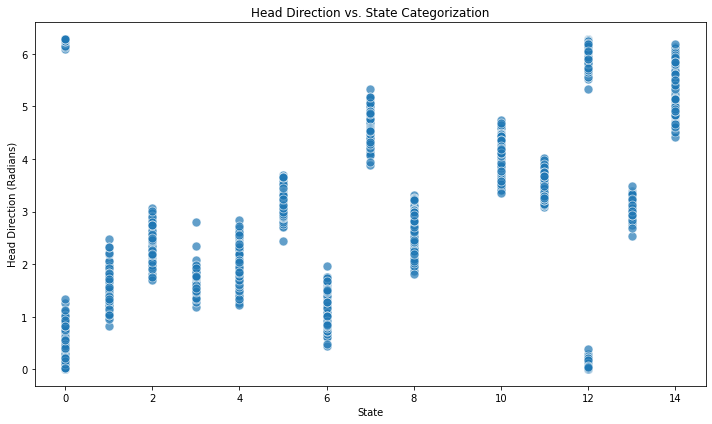

In [29]:
scatterplot_with_color(y, states_head)

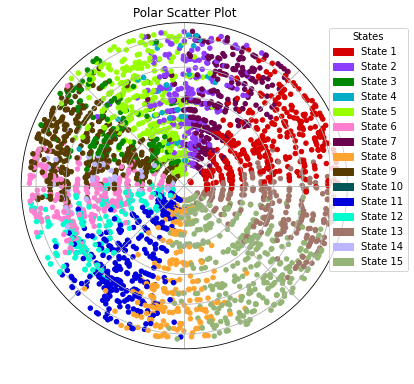

In [30]:
plot_polar_scatter(y, states_head)

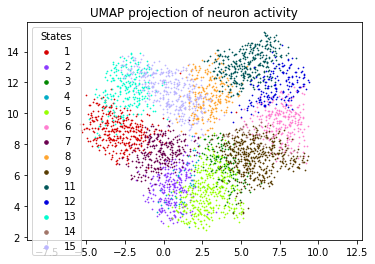

In [31]:
# Assuming `embedding`, `states_head`, and `df` are defined appropriately

states_head_pure = states_head[~np.isnan(df["headAngel"])]
unique_states = np.unique(states_head_pure)
custom_palette = sns.color_palette(cc.glasbey, len(unique_states))

# Create a scatter plot with labels
scatter_handles = []
for i, state in enumerate(unique_states):
    indices = np.where(states_head_pure == state)[0]
    scatter = plt.scatter(
        embedding[indices, 0],
        embedding[indices, 1],
        c=[custom_palette[i]],
        s=0.5,
        marker = "o",
        label=state+1)
    scatter_handles.append(scatter)

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of neuron activity')

# Create a legend based on the scatter plot handles
plt.legend(handles=scatter_handles, title='States', markerscale = 5)

# Show the plot
plt.show()


# Multiple itterations

In [38]:
state_vectors = pd.DataFrame()
num_states = [2,3,4,5,6,7,8,9,10,11]
scores = np.zeros(len(num_states), dtype="float")

i = 0
for n_states in num_states:
    X = X_pd
    n_retraining = 5

    model_list = list()
    score_list = list()
    start_time = time.time()

    for idx in range(n_retraining):
        model = hmm.PoissonHMM(n_components = n_states, verbose=False, random_state = idx, n_iter=15, tol = 500)
        try:
            model.fit(X)
        except:
            score_list.append(-np.inf)
            continue
        
        model_list.append(model)
        score_list.append(model.score(X))
        print(f'Converged: {model.monitor_.converged}\t\t'
                f'Score: {score_list[-1]}')
    print("--- %s seconds ---" % (time.time() - start_time))
    print("Best likelihood:", np.max(score_list))
    
    model = model_list[np.argmax(score_list)]
    states_head = model.predict(X)
    state_vectors[str(n_states)] = states_head
    scores[i] = metrics.silhouette_score(X, states_head, metric='euclidean')
    i += 1
    

Converged: True		Score: -1119722.9388725578
Converged: True		Score: -1096894.138977418
Converged: True		Score: -1103607.444042509
Converged: True		Score: -1119729.825281068
Converged: True		Score: -1110288.2253579127
--- 16.955159902572632 seconds ---
Best likelihood: -1096894.138977418
Converged: True		Score: -1016378.9596854027
Converged: True		Score: -1016145.4111513459
Converged: True		Score: -1016161.7871482656
Converged: True		Score: -1016128.8465563434
Converged: True		Score: -1016280.8689699504
--- 22.064207315444946 seconds ---
Best likelihood: -1016128.8465563434
Converged: True		Score: -998843.815922246
Converged: True		Score: -973442.9244549396
Converged: True		Score: -989343.1212116269
Converged: True		Score: -976551.5717289522
Converged: True		Score: -973107.0426267338
--- 35.005892515182495 seconds ---
Best likelihood: -973107.0426267338
Converged: True		Score: -960007.1150116243
Converged: True		Score: -949134.3133216844
Converged: True		Score: -956321.4860943562
Conver

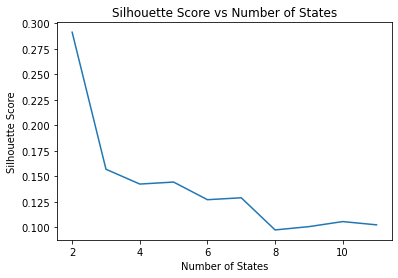

In [39]:
plt.plot(num_states, scores)

plt.xlabel('Number of States')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of States')
plt.show()